In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import tqdm

# %matplotlib widget

In [161]:
class Dense(object):
    def __init__(self, out_dim, inp_dim=None, reg=0.001):
        self.W = None
        self.b = np.random.normal(0, 0.2, out_dim)
        self.reg = reg
        self.out_dim = out_dim
        self.inp_dim = inp_dim
        self.inp = None
        self.next = None
        self.momment1 = None
        self.momment2 = None
        self.momment_b1 = np.zeros_like(self.b)
        self.momment_b2 = np.zeros_like(self.b)
        if inp_dim:
            # self.W = np.random.normal(0, 1, (self.out_dim, self.inp_dim))
            self.W = np.random.normal(0, np.sqrt(2.0/(self.out_dim + self.inp_dim)), (self.out_dim, self.inp_dim))
            self.momment1 = np.zeros_like(self.W)
            self.momment2 = np.zeros_like(self.W)

    def __call__(self, inp=None):
        self.inp = inp
        inp.next = self
        self.inp_dim = inp.out_dim
        # self.W = np.random.normal(0, 1, (self.out_dim, self.inp_dim))
        self.W = np.random.normal(0, np.sqrt(2.0/(self.out_dim + self.inp_dim)), (self.out_dim, self.inp_dim))
        self.momment1 = np.zeros_like(self.W)
        self.momment2 = np.zeros_like(self.W)
        return self
    
    def __repr__(self):
        return (self.__class__.__name__ + ' output: ' + str(self.out_dim) + ' input: ' + str(self.inp_dim))

    def forward(self, X, y=None, W=None, b=None):
        self.X = X
        if len(self.X.shape) > 2:
            X = X.reshape(-1, X.shape[-1])
        if not W:
            W = self.W
        if not b:
            b = self.b
        out = np.dot(W, X.T).T + b

        if len(self.X.shape) > 2:
            out = out.reshape(*self.X.shape[:-1], self.out_dim)
        return out # logits
    
    def backward(self, dO):
        dO_shape = dO.shape
        X = self.X
        if len(dO_shape) > 2 or len(self.X.shape) > 2:
            dO = dO.reshape(-1, dO.shape[-1])
            X = X.reshape(-1, self.X.shape[-1])
        
        dW = np.sum(X[:, np.newaxis, :] * dO[:, :, np.newaxis], axis=0) + self.reg*self.W
        dX = np.sum(self.W[:, :, np.newaxis] * dO.T[:, np.newaxis, :], axis=0).T
        db = np.sum(dO, axis=0)
        
        if len(self.X.shape) > 2:
            dX = dX.reshape(self.X.shape)
        return (dX, dW, db)
    
class LSTM(object):
    # inputs will include a mask
    # if return_seq is false, the last output will be determined using the mask
    def __init__(self, hidden_units, inp_dim=None, return_seq=True, return_mask=False, reg=0.001):
        self.W = None
        self.b = None
        self.reg = reg
        self.out_dim = hidden_units
        self.inp_dim = inp_dim
        self.next = None
        self.return_seq = return_seq
        self.return_mask = return_mask
        self.b = np.random.normal(0, 0.2, (4, self.out_dim))
        self.bf = self.b[0]
        self.bi = self.b[1]
        self.bo = self.b[2]
        self.bc = self.b[3]
        self.momment1 = None
        self.momment2 = None
        self.momment_b1 = np.zeros_like(self.b)
        self.momment_b2 = np.zeros_like(self.b)
        if inp_dim:
            self.W = np.random.normal(0, np.sqrt(2.0/(2 * self.out_dim + self.inp_dim)), (self.out_dim * 4, self.inp_dim + self.out_dim))
            self.Wf = self.W[:self.out_dim, :]
            self.Wi = self.W[self.out_dim: 2 * self.out_dim, :]
            self.Wo = self.W[2 * self.out_dim: 3 * self.out_dim, :]
            self.Wc = self.W[3 * self.out_dim:, :]
            self.b = np.random.normal(0, 0.2, 4 * self.out_dim)
            self.momment1 = np.zeros((self.out_dim * 4, self.inp_dim + self.out_dim))
            self.momment2 = np.zeros((self.out_dim * 4, self.inp_dim + self.out_dim))

    
    def __call__(self, inp):
        self.inp = inp
        inp.next = self
        self.inp_dim = inp.out_dim
        self.W = np.random.normal(0, np.sqrt(2.0/(2 * self.out_dim + self.inp_dim)), (self.out_dim * 4, self.inp_dim + self.out_dim))
        self.Wf = self.W[:self.out_dim, :]
        self.Wi = self.W[self.out_dim: 2 * self.out_dim, :]
        self.Wo = self.W[2 * self.out_dim: 3 * self.out_dim, :]
        self.Wc = self.W[3 * self.out_dim:, :]
        self.momment1 = np.zeros((self.out_dim * 4, self.inp_dim + self.out_dim))
        self.momment2 = np.zeros((self.out_dim * 4, self.inp_dim + self.out_dim))
        return self
    
    def __repr__(self):
        return (self.__class__.__name__ + ' output: ' + str(self.out_dim) + ' input: ' + str(self.inp_dim))
    
    @staticmethod
    def sigmoid(X):
        return 1.0/(1.0 + np.exp(-1 * X))
    
    def forward(self, X, y=None, W=None, b=None):
        #W = out x in
        self.Wf = self.W[:self.out_dim, :]
        self.Wi = self.W[self.out_dim: 2 * self.out_dim, :]
        self.Wo = self.W[2 * self.out_dim: 3 * self.out_dim, :]
        self.Wc = self.W[3 * self.out_dim:, :]

        self.bf = self.b[0]
        self.bi = self.b[1]
        self.bo = self.b[2]
        self.bc = self.b[3]

        if isinstance(X, dict):
            X_ = X
            X = X_['input_ids']
            mask = X_.get('seq_lens', np.array(X.shape[1]).repeat(X.shape[0]))
        else:
            mask = np.array(X.shape[1]).repeat(X.shape[0])
        fg = np.zeros((X.shape[0], X.shape[1] + 1, self.out_dim))
        ig = np.zeros((X.shape[0], X.shape[1] + 1, self.out_dim))
        og = np.zeros((X.shape[0], X.shape[1] + 1, self.out_dim))
        pstate = np.zeros((X.shape[0], X.shape[1] + 1, self.out_dim))
        state = np.zeros((X.shape[0], X.shape[1] + 1, self.out_dim))
        out = np.zeros((X.shape[0], X.shape[1] + 1, self.out_dim))
        X = np.concatenate([np.zeros((X.shape[0], 1, X.shape[2])), X], axis=1) # shape of X is (N, T, d)
        self.X = X
        self.mask = mask
        
        for t in range(1, X.shape[1]):
            fg[:, t, :] = self.sigmoid(np.dot(np.hstack([out[:, t - 1, :], X[:, t, :]]), self.Wf.T) + self.bf)
            ig[:, t, :] = self.sigmoid(np.dot(np.hstack([out[:, t - 1, :], X[:, t, :]]), self.Wi.T) + self.bi)
            pstate[:, t, :] = np.tanh(np.dot(np.hstack([out[:, t - 1, :], X[:, t, :]]), self.Wc.T) + self.bc)
            state[:, t, :] = fg[:, t, :] * state[:, t - 1, :] + ig[:, t, :] * pstate[:, t, :]
            og[:, t, :] = self.sigmoid(np.dot(np.hstack([out[:, t - 1, :], X[:, t, :]]), self.Wo.T) + self.bo)
            out[:, t, :] = og[:, t, :] * np.tanh(state[:, t, :])
        self.fg = fg
        self.ig = ig
        self.og = og
        self.pstate = pstate
        self.state = state
        self.out = out
        out = out[:, 1:, :] if self.return_seq else out[np.arange(X.shape[0]), mask, :]
        # return out[:, 1:, :] if self.return_seq else out[np.arange(X.shape[0]), mask, :]
        return {'input_ids': out, 'seq_lens': mask} if self.return_mask else out

    def backward(self, dO):
        if not self.return_seq:
            dO_ = np.zeros_like(self.out)
            dO_[np.arange(self.X.shape[0]), self.mask, :] = dO
            dO = dO_
        else:
            dO = np.concatenate([np.zeros((dO.shape[0], 1, dO.shape[2])), dO], axis=1)
        # print (dO)
        dstate = np.zeros_like(self.state)
        dWo = np.zeros_like(self.Wo)
        dWi = np.zeros_like(self.Wi)
        dWf = np.zeros_like(self.Wf)
        dWc = np.zeros_like(self.Wc)
        dbf = np.zeros_like(self.bf)
        dbi = np.zeros_like(self.bi)
        dbo = np.zeros_like(self.bo)
        dbc = np.zeros_like(self.bc)
        dX = np.zeros_like(self.X)
        mask = np.arange(self.X.shape[1]) > self.mask[:, np.newaxis]
        for t in range(self.X.shape[1] - 1, 0, -1):
            dstate[:, t, :] += dO[:, t, :] * self.og[:, t, :] * (1 - np.square(np.tanh(self.state[:, t, :])))
            dstate[:, t - 1, :] = dstate[:, t, :] * self.fg[:, t, :]
            
            dWo += np.dot((dO[:, t, :] * np.tanh(self.state[:, t, :]) * self.og[:, t, :] * (1 - self.og[:, t, :])).T, 
                          np.hstack([self.out[:, t, :], self.X[:, t, :]]))
            dWi += np.dot((dstate[:, t, :] * self.pstate[:, t, :] * self.ig[:, t, :] * (1 - self.ig[:, t, :])).T, 
                          np.hstack([self.out[:, t, :], self.X[:, t, :]]))
            dWf += np.dot((dstate[:, t, :] * self.state[:, t - 1, :] * self.fg[:, t, :] * (1 - self.fg[:, t, :])).T, 
                          np.hstack([self.out[:, t, :], self.X[:, t, :]]))
            dWc += np.dot((dstate[:, t, :] * self.ig[:, t, :] * (1 - np.square(self.pstate[:, t, :]))).T,
                          np.hstack([self.out[:, t, :], self.X[:, t, :]]))
            
            dO[:, t - 1, :] += np.dot(dstate[:, t, :] * self.ig[:, t, :] * (1 - np.square(self.pstate[:, t, :])), self.Wc[:, :self.out_dim])\
                            + np.dot(dstate[:, t, :] * self.state[:, t - 1, :] * self.fg[:, t, :] * (1 - self.fg[:, t, :]), self.Wf[:, :self.out_dim])\
                            + np.dot(dstate[:, t, :] * self.pstate[:, t, :] * self.ig[:, t, :] * (1 - self.ig[:, t, :]), self.Wi[:, :self.out_dim])\
                            + np.dot(dO[:, t, :] * np.tanh(self.state[:, t, :]) * self.og[:, t, :] * (1 - self.og[:, t, :]), self.Wo[:, :self.out_dim])
            
            dX[:, t, :] = np.dot(dstate[:, t, :] * self.ig[:, t, :] * (1 - np.square(self.pstate[:, t, :])), self.Wc[:, self.out_dim:])\
                        + np.dot(dstate[:, t, :] * self.state[:, t - 1, :] * self.fg[:, t, :] * (1 - self.fg[:, t, :]), self.Wf[:, self.out_dim:])\
                        + np.dot(dstate[:, t, :] * self.pstate[:, t, :] * self.ig[:, t, :] * (1 - self.ig[:, t, :]), self.Wi[:, self.out_dim:])\
                        + np.dot(dO[:, t, :] * np.tanh(self.state[:, t, :]) * self.og[:, t, :] * (1 - self.og[:, t, :]), self.Wo[:, self.out_dim:])

            dbo += (dO[:, t, :] * np.tanh(self.state[:, t, :]) * self.og[:, t, :] * (1 - self.og[:, t, :])).sum(axis=0)
            dbi += (dstate[:, t, :] * self.pstate[:, t, :] * self.ig[:, t, :] * (1 - self.ig[:, t, :])).sum(axis=0)
            dbf += (dstate[:, t, :] * self.state[:, t - 1, :] * self.fg[:, t, :] * (1 - self.fg[:, t, :])).sum(axis=0)
            dbc += (dstate[:, t, :] * self.ig[:, t, :] * (1 - np.square(self.pstate[:, t, :]))).sum(axis=0)

        dW = np.vstack([dWf, dWi, dWo, dWc]) + self.reg * self.W
        db = np.vstack([dbf, dbi, dbo, dbc])
        # print ('dX')
        # print (dX)
        # print ('dstate')
        # print (dstate)
        dX[mask, :] = 0
        return (dX[:, 1:, :], dW, db)
    
class Embeddings(object):
    def __init__(self, num_embeddings, embedding_dim, pad_idx=None, trainable=True, reg=0.0001):
        self.W = None
        self.b = 0.
        self.reg = reg
        self.out_dim = embedding_dim
        self.inp_dim = num_embeddings
        self.pad_idx = pad_idx
        self.trainable = trainable
        self.inp = None
        self.next = None
        self.momment1 = None
        self.momment2 = None
        if num_embeddings:
            self.W = np.random.normal(0, 1, (self.out_dim, self.inp_dim))
            self.momment1 = np.zeros_like(self.W)
            self.momment2 = np.zeros_like(self.W)

    def __call__(self, inp):
        self.inp = inp
        inp.next = self
        if self.inp_dim != inp.out_dim:
            raise ValueError('num_embeddings do not match out_dim of inputs')
        return self
    
    def __repr__(self):
        return (self.__class__.__name__ + ' embedding_dim: ' + str(self.out_dim) + ' num_embeddings: ' + str(self.inp_dim))
    
    def forward(self, X, y=None):
        self.X = X
        # inputs are encoded tokens with token_ids
        # shape of X: (N, T)
        
        out = np.take(self.W.T, X, axis=0)
        # output shape: N, T, emb_dim
        if self.pad_idx is not None:
            mask = (X != self.pad_idx).sum(axis=1)
        return out if self.pad_idx is None else {'input_ids': out, 'seq_lens': mask}
    
    def backward(self, dO):
        dW = np.zeros_like(self.W)
        # dW[:, self.X] += dO
        if self.trainable:
            np.add.at(dW.T, np.s_[self.X, :], dO)
        # dW += self.reg * self.W
        return 0, dW, None

    
class Activation(object):
    def __init__(self, func='relu'): # options: relu, softmax_with_cat_cross_entropy (softmax)
        self.act_function = func
        self.next = None

    def __call__(self, inp=None):
        self.inp = inp
        inp.next = self
        self.inp_dim = inp.out_dim
        self.out_dim = self.inp_dim
        return self
    
    def __repr__(self):
        return (self.__class__.__name__ + ' ' + self.act_function + ' output: ' + str(self.out_dim) + ' input: ' + str(self.inp_dim))
    
    def forward(self, X, y=None):
        self.X = X
        self.y = y
        if self.act_function == 'relu':
            out = np.maximum(0, X)
            activations = out
        elif self.act_function == 'softmax':
            exps = np.exp(X - np.max(X, axis=1, keepdims=True))
            activations = exps / np.sum(exps, axis=1, keepdims=True)
            activations = np.where(activations > 1.0e-10, activations, 1.0e-10)
            out = np.mean(-1*np.sum(y * np.log(activations), axis=1))
        elif self.act_function == 'sigmoid_with_bin_cross_entropy':
            sig = 1/(1 + np.exp(-X))
            activations = sig
            activations = np.where(activations > 1.0e-10, activations, 1.0e-10)
            out = np.mean(-1*((y * np.log(activations)) + ((1 - y) * np.log(1 - activations))))
        elif self.act_function == 'sigmoid':
            activations = 1/(1 + np.exp(-X))
            activations = np.where(activations > 1.0e-7, activations, 1.0e-7)
            activations = np.where(activations < 1 - 1.0e-7, activations, 1 - 1.0e-7)
            out = activations
        self.activations = activations
        return out
    
    def predict(self, X, y=None):
        _ = self.forward(X, y)
        return self.activations
    
    def backward(self, dO=None):
        if self.act_function == 'relu':
            dX = np.where(self.X < 0, 0, 1) * dO
        elif self.act_function == 'softmax' or self.act_function == 'sigmoid_with_bin_cross_entropy':
            dX = self.activations - self.y
        elif self.act_function == 'sigmoid':
            dX = self.activations * (1 - self.activations) * dO
        return (dX, None, None)
    
class Loss(object):
    def __init__(self, loss_fn): # options: mse
        self.loss_function = loss_fn
        self.next = None

    def __call__(self, inp):
        self.inp = inp
        inp.next = self
        self.inp_dim = inp.out_dim
        self.out_dim = self.inp_dim
        return self
    
    def __repr__(self):
        return (self.__class__.__name__ + ' ' + self.loss_function + ' output: ' + str(self.out_dim) + ' input: ' + str(self.inp_dim))
    
    def forward(self, X, y):
        self.X = X
        self.y = y
        if self.loss_function == 'mse':
            loss = np.mean((X - y)**2)
        return loss
    
    def predict(self, X, y=None):
        return X
    
    def backward(self, dO=None):
        if self.loss_function == 'mse':
            dX = 2*(self.X - self.y)
        return (dX, None, None)

class Optimizer(object): # Adam implementation
    def __init__(self, lr=0.001, b1=0.9, b2=0.999):
        self.b1, self.b2 = b1, b2
        self.eps = 1e-8
        self.t = 1
        self.lr = lr
        self.loss = []

    def run_forward(self, input_layer, X, y):
        layer = input_layer
        out = X
        while (layer):
            # print (layer)
            # print (out.shape)
            out = layer.forward(out, y)
            layer = layer.next
        loss = out
        return loss

    def optimize_step(self, out_layer, verbose=False):
        layer = out_layer 
        t = self.t
        dO = 1  
        lr = self.lr 
        while (layer):
            # print (layer)
            dO, dW, db = layer.backward(dO)
            if dW is not None:
                moment1 = (self.b1 * layer.momment1) + ((1 - self.b1) * dW)
                moment2 = (self.b2 * layer.momment2) + ((1 - self.b2) * dW**2)
                mt1_hat = moment1/(1 - self.b1**t)
                mt2_hat = moment2/(1 - self.b2**t)
                # W = layer.W - (lr * dW)
                W = layer.W - (lr * mt1_hat/(np.sqrt(mt2_hat) + self.eps))
                layer.W = W
                layer.momment1 = moment1
                layer.momment2 = moment2
                if verbose >= 10:
                    print (layer)
                    print ('dW:', dW)
                    print ("updated W:")
                    print (W)

            if db is not None:
                moment_b1 = (self.b1 * layer.momment_b1) + ((1 - self.b1) * db)
                moment_b2 = (self.b2 * layer.momment_b2) + ((1 - self.b2) * db**2)
                mt1_hat = moment_b1/(1 - self.b1**t)
                mt2_hat = moment_b2/(1 - self.b2**t)
                # b = layer.b - (lr * db)
                b = layer.b - (lr * mt1_hat/(np.sqrt(mt2_hat) + self.eps))
                layer.b = b
                layer.momment_b1 = moment_b1
                layer.momment_b2 = moment_b2
                if verbose >= 10:
                    print ('db:', db)
                    print ("updated b:", b)

            self.t = t + 1
            layer = layer.inp
        return self.t

    def train(self, input_layer, out_layer, 
              X, y, batch_size=None, 
              patience=20, epochs=None, 
              verbose=False, loss_tr_ep=1.0e-10,
              inputs_batched=False):
        patience = patience
        loss_tracker = []
        epoch = 0
        if not epochs:
            epochs = 1e10
        if not patience:
            patience = epochs + 1
        patience_remaining = patience
        
        if not isinstance(batch_size, int) and not inputs_batched:
            batch_size = X.shape[0]
        elif inputs_batched:
            batch_size = X[0].shape[0]
        
        num_batches = len(X) if inputs_batched else int(np.ceil(X.shape[0]/batch_size))
        
        print ("Using batch_size of", batch_size)
        while (patience_remaining > 0 and epochs > epoch):
            loss_tracker_epoch = []
            for i in tqdm.tqdm(range(num_batches), disable=not verbose):
                if inputs_batched: # X is list of precreated batched
                    X_batch = X[i]
                    y_batch = y[i]
                else: # X is the entire data and batches are created here
                    up_ind = min(X.shape[0], (i + 1) * batch_size)
                    X_batch = X[i * batch_size: up_ind]
                    y_batch = y[i * batch_size: up_ind]
                loss = self.run_forward(input_layer, X_batch, y_batch)
                timestep = self.optimize_step(out_layer, verbose=verbose)
                loss_tracker_epoch.append(loss)
            epoch_loss = np.mean(loss_tracker_epoch)
            epoch += 1
            
            if len(loss_tracker) > 0 and epoch_loss + loss_tr_ep > min(loss_tracker):
                patience_remaining -= 1
            else:
                patience_remaining = patience
            loss_tracker.append(epoch_loss)

            print ('epoch:', epoch, 'loss:', epoch_loss)
        self.loss = self.loss + loss_tracker
    
    def predict(self, input_layer, X, y, batch_size=None, verbose=False):
        out_list = []
        if not isinstance(batch_size, int):
            batch_size = X.shape[0]
        print ("Using batch_size of", batch_size)
        for i in range(int(np.ceil(X.shape[0]/batch_size))):
            up_ind = min(X.shape[0], (i + 1) * batch_size)
            X_batch = X[i * batch_size: up_ind]
            y_batch = y[i * batch_size: up_ind]
            layer = input_layer
            out = X_batch
            while (layer):
                # print (layer)
                # print (out.shape)
                if isinstance(layer, (Activation, Loss)):
                # if isinstance(layer, relu1.__class__):
                    out = layer.predict(out, y_batch)
                else:
                    out = layer.forward(out, y_batch)
                if verbose:
                    print (layer)
                    print (out)
                layer = layer.next
            out_list.append(out)
        return np.vstack(out_list)


In [189]:
!pyreverse -o png neural_network.py

Format png is not supported natively. Pyreverse will try to generate it using Graphviz...


## Experiment 1

In [3]:
from irony import load_datasets
from sklearn.model_selection import train_test_split

train_sentences, train_labels, test_sentences, test_labels, label2i = load_datasets()

# TODO: Split train into train/dev
train_sentences, dev_sentences, train_labels, dev_labels = train_test_split(train_sentences, train_labels, train_size=0.8)

In [4]:
from irony import run_nb_baseline

run_nb_baseline()

Vectorizing Text: 100%|██████████| 784/784 [00:00<00:00, 26935.24it/s]

Baseline: Naive Bayes Classifier
F1-score Ironic: 0.6402966625463535
Avg F1-score: 0.6284487265300938


In [5]:
from typing import Dict, List, Optional, Tuple
from collections import Counter

import numpy as np
import spacy


class Tokenizer:
    """Tokenizes and pads a batch of input sentences."""

    def __init__(self, pad_symbol: Optional[str] = "<PAD>"):
        """Initializes the tokenizer

        Args:
            pad_symbol (Optional[str], optional): The symbol for a pad. Defaults to "<PAD>".
        """
        self.pad_symbol = pad_symbol
        self.nlp = spacy.load("en_core_web_lg")
    
    def __call__(self, batch: List[str]) -> List[List[str]]:
        """Tokenizes each sentence in the batch, and pads them if necessary so
        that we have equal length sentences in the batch.

        Args:
            batch (List[str]): A List of sentence strings

        Returns:
            List[List[str]]: A List of equal-length token Lists.
        """
        batch = self.tokenize(batch)
        batch = self.pad(batch)

        return batch

    def tokenize(self, sentences: List[str]) -> List[List[str]]:
        """Tokenizes the List of string sentences into a Lists of tokens using spacy tokenizer.

        Args:
            sentences (List[str]): The input sentence.

        Returns:
            List[str]: The tokenized version of the sentence.
        """
        tokenized_sents = []
        # TODO: Tokenize the input with spacy.
        for sent in sentences:
            sent_tokens = [token.text.lower() for token in self.nlp(sent)]
        # TODO: Make sure the start token is the special <SOS> token and the end token
        #       is the special <EOS> token
            sent_tokens = ['<SOS>'] + sent_tokens + ['<EOS>']
            tokenized_sents.append(sent_tokens)

        return tokenized_sents

    def pad(self, batch: List[List[str]]) -> List[List[str]]:
        """Appends pad symbols to each tokenized sentence in the batch such that
        every List of tokens is the same length. This means that the max length sentence
        will not be padded.

        Args:
            batch (List[List[str]]): Batch of tokenized sentences.

        Returns:
            List[List[str]]: Batch of padded tokenized sentences. 
        """
        # TODO: For each sentence in the batch, append the special <P>
        #       symbol to it n times to make all sentences equal length
        out_batch = []
        max_len = max([len(sent) for sent in batch])
        for sent in batch:
            out_batch.append(sent + [self.pad_symbol]*(max_len - len(sent)))
        return out_batch
        

In [6]:
# create the vocabulary of the dataset: use both training and test sets here

SPECIAL_TOKENS = ['<UNK>', '<PAD>', '<SOS>', '<EOS>']

all_data = train_sentences + dev_sentences + test_sentences
my_tokenizer = Tokenizer()

tokenized_data = my_tokenizer.tokenize(all_data)
vocab = sorted(set([w for ws in tokenized_data + [SPECIAL_TOKENS] for w in ws]))

with open('vocab.txt', 'w') as vf:
    vf.write('\n'.join(vocab))

In [7]:
embedding_path = 'glove.twitter.27B.100d.txt'
vocab_path = "./vocab.txt"

In [8]:
from typing import Dict, Tuple

# import torch


def read_pretrained_embeddings(
    embeddings_path: str,
    vocab_path: str
) -> Tuple[Dict[str, int], np.ndarray]:
    """Read the embeddings matrix and make a dict hashing each word.

    Note that we have provided the entire vocab for train and test, so that for practical purposes
    we can simply load those words in the vocab, rather than all 27B embeddings

    Args:
        embeddings_path (str): _description_
        vocab_path (str): _description_

    Returns:
        Tuple[Dict[str, int], torch.FloatTensor]: _description_
    """
    word2i = {}
    vectors = []
    
    with open(vocab_path, encoding='utf8') as vf:
        vocab = set([w.strip() for w in vf.readlines()]) 
    
    print(f"Reading embeddings from {embeddings_path}...")
    with open(embeddings_path, "r") as f:
        i = 0
        for line in f:
            word, *weights = line.rstrip().split(" ")
            # TODO: Build word2i and vectors such that
            #       each word points to the index of its vector,
            #       and only words that exist in `vocab` are in our embeddings
            if word in vocab:
                word2i.update({word: i})
                vectors.append(weights)
                i += 1
            # raise NotImplementedError

    return (word2i, np.array(vectors, dtype=np.float32))

In [9]:
def get_oovs(vocab_path: str, word2i: Dict[str, int]) -> List[str]:
    """Find the vocab items that do not exist in the glove embeddings (in word2i).
    Return the List of such (unique) words.

    Args:
        vocab_path: List of batches of sentences.
        word2i (Dict[str, int]): _description_

    Returns:
        List[str]: _description_
    """
    with open(vocab_path, encoding='utf8') as vf:
        vocab = set([w.strip() for w in vf.readlines()])
    
    glove_and_vocab = set(word2i.keys())
    vocab_and_not_glove = vocab - glove_and_vocab
    return list(vocab_and_not_glove)

def intialize_new_embedding_weights(num_embeddings: int, dim: int) -> np.ndarray:
    """xavier initialization for the embeddings of words in train, but not in gLove.

    Args:
        num_embeddings (int): _description_
        dim (int): _description_

    Returns:
        torch.FloatTensor: _description_
    """
    # TODO: Initialize a num_embeddings x dim matrix with xiavier initiialization
    #      That is, a normal distribution with mean 0 and standard deviation of dim^-0.5
    oov_emb = np.random.normal(0, 1/np.sqrt(dim), (num_embeddings, dim))
    return oov_emb


def update_embeddings(
    glove_word2i: Dict[str, int],
    glove_embeddings: np.ndarray,
    oovs: List[str]
) -> Tuple[Dict[str, int], np.ndarray]:
    # TODO: Add the oov words to the dict, assigning a new index to each
    max_ind = max(glove_word2i.values())
    glove_word2i.update({oov: new_ind for oov, new_ind in zip(oovs, range(max_ind + 1, max_ind + 1 + len(oovs)))})
    # TODO: Concatenate a new row to embeddings for each oov
    #       initialize those new rows with `intialize_new_embedding_weights`
    new_glove_embeddings = np.vstack((glove_embeddings, intialize_new_embedding_weights(len(oovs), glove_embeddings.shape[1])))
    # TODO: Return the tuple of the dictionary and the new embeddings matrix
    return glove_word2i, new_glove_embeddings


In [10]:
def make_batches(sequences: List[str], batch_size: int) -> List[List[str]]:
    """Yield batch_size chunks from sequences."""
    # TODO
    for i in range(0, len(sequences), batch_size):
        yield sequences[i: i + batch_size]


# TODO: Set your preferred batch size
batch_size = 16
tokenizer = Tokenizer()

# We make batches now and use those.
batch_tokenized = []
# Note: Labels need to be batched in the same way to ensure
# We have train sentence and label batches lining up.
for batch in make_batches(train_sentences, batch_size):
    batch_tokenized.append(tokenizer(batch))


glove_word2i, glove_embeddings = read_pretrained_embeddings(
    embedding_path,
    vocab_path
)

# Find the out-of-vocabularies
oovs = get_oovs(vocab_path, glove_word2i)

# Add the oovs from training data to the word2i encoding, and as new rows
# to the embeddings matrix
word2i, embeddings = update_embeddings(glove_word2i, glove_embeddings, oovs)

Reading embeddings from /Users/anupbhutada/Documents/Courses/Natural Langauge Processing/Assignment4/assignment_4/glove.twitter.27B.100d.txt...


In [11]:
len(oovs), len(word2i)

(6002, 15299)

In [12]:
# Use these functions to encode your batches before you call the train loop.

def encode_sentences(batch: List[List[str]], word2i: Dict[str, int]) -> np.ndarray:
    """Encode the tokens in each sentence in the batch with a dictionary

    Args:
        batch (List[List[str]]): The padded and tokenized batch of sentences.
        word2i (Dict[str, int]): The encoding dictionary.

    Returns:
        torch.LongTensor: The tensor of encoded sentences.
    """
    UNK_IDX = word2i["<UNK>"]
    tensors = []
    for sent in batch:
        tensors.append(np.array([word2i.get(w, UNK_IDX) for w in sent], dtype='int'))
        
    return np.stack(tensors)


def encode_labels(labels: List[int]) -> np.ndarray:
    """Turns the batch of labels into a tensor

    Args:
        labels (List[int]): List of all labels in the batch

    Returns:
        torch.FloatTensor: Tensor of all labels in the batch
    """
    arr = np.array([int(l) for l in labels], dtype='int')
    out = np.zeros((arr.shape[0], 2))
    out[np.arange(arr.shape[0]), arr] = 1
    return out

In [13]:
# TODO: Load the model and run the training loop 
#       on your train/dev splits. Set and tweak hyperparameters.
batch_size = 32

print ("Creating batches...")
batch_train_tokenized = []
batch_tokenized_train = [tokenizer(batch) for batch in make_batches(train_sentences, batch_size)]
batch_labels_train = list(make_batches(train_labels, batch_size))
batch_tokenized_dev = [tokenizer(batch) for batch in make_batches(dev_sentences, batch_size)]
batch_labels_dev = list(make_batches(dev_labels, batch_size))

# print ("Encoding batches...")
# batch_sentences_train = [encode_sentences(batch, word2i) for batch in batch_tokenized_train]
# batch_labels_train = [encode_labels(batch_labels).reshape(-1, 1) for batch_labels in batch_labels_train]
# batch_sentences_dev = [encode_sentences(batch, word2i) for batch in batch_tokenized_dev]
# batch_labels_dev = [encode_labels(batch_labels).reshape(-1, 1) for batch_labels in batch_labels_dev]

print ("Encoding batches...")
batch_sentences_train = [encode_sentences(batch, word2i) for batch in batch_tokenized_train]
batch_labels_train = [encode_labels(batch_labels) for batch_labels in batch_labels_train]
batch_sentences_dev = [encode_sentences(batch, word2i) for batch in batch_tokenized_dev]
batch_labels_dev = [encode_labels(batch_labels) for batch_labels in batch_labels_dev]

print ("DONE")


Creating batches...
Encoding batches...
DONE


In [14]:
## create model
embedding_layer = Embeddings(num_embeddings=embeddings.shape[0], 
                             embedding_dim=embeddings.shape[1], 
                             pad_idx=word2i.get('<PAD>'),
                             trainable=False)
embedding_layer.W = embeddings.T.copy()
lstm1 = LSTM(hidden_units=32, return_seq=True, return_mask=True, reg=0.0)(embedding_layer)
lstm = LSTM(hidden_units=32, return_seq=False, return_mask=False, reg=0.0)(lstm1)
dense = Dense(out_dim=2, reg=0.0)(lstm)
out = Activation(func='softmax')(dense)


In [15]:
opt = Optimizer(lr=0.0005)
# opt.run_forward(embedding_layer, batch_sentences_train[0][:2], np.array([[1], [0]]))

In [16]:
opt.train(embedding_layer, out, batch_sentences_train, batch_labels_train, epochs=20, verbose=True, inputs_batched=True)

Using batch_size of 32


100%|██████████| 96/96 [00:03<00:00, 24.60it/s]


epoch: 1 loss: 0.6884177935424688


100%|██████████| 96/96 [00:03<00:00, 24.93it/s]


epoch: 2 loss: 0.6641607605096858


100%|██████████| 96/96 [00:03<00:00, 25.20it/s]


epoch: 3 loss: 0.6286235340228834


100%|██████████| 96/96 [00:03<00:00, 25.08it/s]


epoch: 4 loss: 0.6063061208429191


100%|██████████| 96/96 [00:03<00:00, 25.39it/s]


epoch: 5 loss: 0.5874331737132356


100%|██████████| 96/96 [00:03<00:00, 25.58it/s]


epoch: 6 loss: 0.5694593180507741


100%|██████████| 96/96 [00:03<00:00, 26.13it/s]


epoch: 7 loss: 0.5511466895116994


100%|██████████| 96/96 [00:03<00:00, 26.26it/s]


epoch: 8 loss: 0.5314960894719287


100%|██████████| 96/96 [00:03<00:00, 25.97it/s]


epoch: 9 loss: 0.5097976162540578


100%|██████████| 96/96 [00:03<00:00, 26.14it/s]


epoch: 10 loss: 0.4855376629201719


100%|██████████| 96/96 [00:03<00:00, 25.93it/s]


epoch: 11 loss: 0.45884225971284387


100%|██████████| 96/96 [00:03<00:00, 26.10it/s]


epoch: 12 loss: 0.43162878524688747


100%|██████████| 96/96 [00:03<00:00, 26.17it/s]


epoch: 13 loss: 0.4034344599635607


100%|██████████| 96/96 [00:03<00:00, 26.08it/s]


epoch: 14 loss: 0.37314261178297264


100%|██████████| 96/96 [00:03<00:00, 25.85it/s]


epoch: 15 loss: 0.34559766941172704


100%|██████████| 96/96 [00:03<00:00, 25.84it/s]


epoch: 16 loss: 0.32636104942973193


100%|██████████| 96/96 [00:03<00:00, 26.27it/s]


epoch: 17 loss: 0.30726614834036575


100%|██████████| 96/96 [00:03<00:00, 24.81it/s]


epoch: 18 loss: 0.3126650088702868


100%|██████████| 96/96 [00:03<00:00, 24.17it/s]


epoch: 19 loss: 0.27736046806577697


100%|██████████| 96/96 [00:03<00:00, 24.52it/s]

epoch: 20 loss: 0.2552353053145164


In [28]:
opt.run_forward(embedding_layer, batch_sentences_dev[0], batch_labels_dev[0])

1.0954325081367962

In [22]:
((opt.predict(embedding_layer, batch_sentences_dev[1], batch_labels_dev[1]) > 0.5).astype('int') == batch_labels_dev[0]).mean()

Using batch_size of 32


0.375

In [17]:
from util import f1_score

def predict_batches(input_layer, batched_X, batched_y):
    all_preds = []
    for X, y in zip(batched_X, batched_y):
        preds = opt.predict(input_layer, X, y)
        all_preds.append(preds)
    return np.vstack(all_preds)

def get_pred_and_true_labels(true_y=None, pred_y=None):
    if true_y is not None:
        true_y = np.argmax(true_y, axis=1)
    if pred_y is not None:
        pred_y = np.argmax(pred_y, axis=1)
    return true_y, pred_y

In [18]:
# Train accuracy
preds = predict_batches(embedding_layer, batch_sentences_train, batch_labels_train)
y_true = np.vstack(batch_labels_train)
((preds > 0.5).astype('float') == y_true).mean()

Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch

0.9142484512552983

In [ ]:
f1_score(*get_pred_and_true_labels(preds, np.vstack(batch_labels_train)))

In [19]:
# Validation accuracy
preds = predict_batches(embedding_layer, batch_sentences_dev, batch_labels_dev)
y_true = np.vstack(batch_labels_dev)
((preds > 0.5).astype('float') == y_true).mean()

Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 31


0.7001303780964798

In [20]:
# Validation F1-score
f1_score(*get_pred_and_true_labels(predict_batches(embedding_layer, batch_sentences_dev, batch_labels_dev), np.vstack(batch_labels_dev)))

Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 32
Using batch_size of 31


0.7081218274111675

In [21]:
test_encoded = encode_sentences(tokenizer(test_sentences), word2i)
test_labels_encoded = encode_labels(test_labels)
# test_labels_encoded = test_labels_encoded

In [23]:
((opt.predict(embedding_layer, test_encoded, test_labels_encoded) > 0.5).astype('int') == test_labels_encoded).mean()

Using batch_size of 784


0.7181122448979592

In [31]:
# Test F1-score
true_y, pred_y = get_pred_and_true_labels(test_labels_encoded, opt.predict(embedding_layer, test_encoded, test_labels_encoded))
print ('f1 score:', f1_score(pred_y, true_y))
print ('acc:', (true_y==pred_y).mean())

Using batch_size of 784
f1 score: 0.6810966810966811
acc: 0.7181122448979592


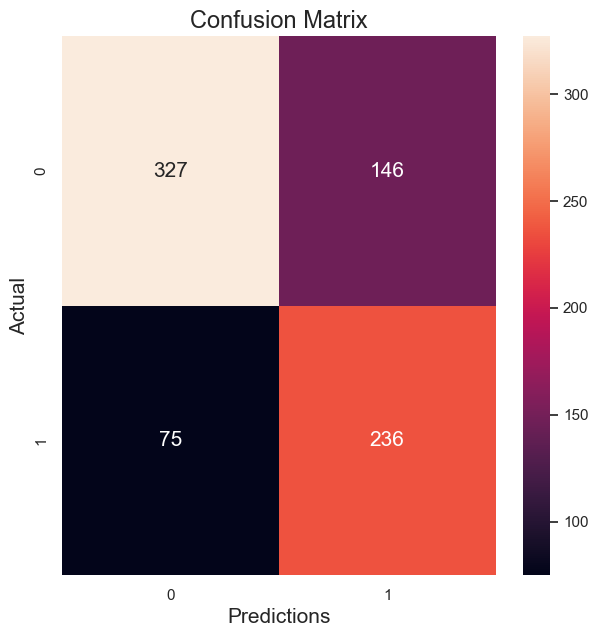

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# np.set_printoptions(precision=2, suppress=True)
import seaborn as sns
# plt.figure(figsize=(20,20))
sns.set(rc={'figure.figsize':(7,7)})
sns.heatmap(confusion_matrix(true_y, pred_y), annot=True, annot_kws={"size": 15}, fmt='g')
plt.ylabel('Actual',fontsize=15)
plt.xlabel('Predictions',fontsize=15)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

## Experiment 2

In [128]:
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from keras.utils import to_categorical

np.set_printoptions(edgeitems=10, linewidth=155)

In [129]:
reuters_data = keras.datasets.reuters
(X_train, y_train),(X_test, y_test) = reuters_data.load_data(num_words=25000)

In [132]:
def pad_batch(batch_X):
    max_len = min(max([len(x) for x in batch_X]), 350)
    return pad_sequences(batch_X, maxlen=max_len, padding='post')

In [133]:
seq_lengths = [len(x) for x in X_train]
np.quantile(np.array(seq_lengths), 0.9)

313.0

In [134]:
X_train = pad_sequences(X_train, maxlen=350, padding='post')
X_test = pad_sequences(X_test, maxlen=350, padding='post')

In [135]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=500)

In [46]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((8482, 350), (8482,), (500, 350), (500,), (2246, 350), (2246,))

In [47]:
# model = Sequential()
# model.add(InputLayer(input_shape=(350,)))
# model.add(Embedding(input_dim=25000, output_dim=64, mask_zero=True))
# model.add(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(46, activation='softmax'))

In [68]:
## create model
embedding_layer = Embeddings(num_embeddings=25000, 
                             embedding_dim=64, 
                             pad_idx=0,
                             trainable=True)
# embedding_layer.W = embeddings.T.copy()
# lstm1 = LSTM(hidden_units=128, return_seq=True, return_mask=True, reg=0.0)(embedding_layer)
lstm = LSTM(hidden_units=128, return_seq=False, return_mask=False, reg=1e-4)(embedding_layer)
dense1 = Dense(out_dim=64, reg=1e-3)(lstm)
act1 = Activation(func='relu')(dense1)
dense = Dense(out_dim=46, reg=1e-3)(act1)
out = Activation(func='softmax')(dense)


In [69]:
opt = Optimizer(lr=5e-3)
# opt.run_forward(embedding_layer, batch_sentences_train[0][:2], np.array([[1], [0]]))

In [70]:
opt.train(embedding_layer, out, X_train, to_categorical(y_train), epochs=20, batch_size=128, verbose=True)

Using batch_size of 128


100%|██████████| 67/67 [03:04<00:00,  2.76s/it]


epoch: 1 loss: 2.255097995458693


100%|██████████| 67/67 [02:32<00:00,  2.28s/it]


epoch: 2 loss: 1.9444503936538982


100%|██████████| 67/67 [02:34<00:00,  2.30s/it]


epoch: 3 loss: 1.7335602995373809


100%|██████████| 67/67 [02:26<00:00,  2.19s/it]


epoch: 4 loss: 1.6407427535242098


100%|██████████| 67/67 [02:25<00:00,  2.17s/it]


epoch: 5 loss: 1.4203145178399144


100%|██████████| 67/67 [02:48<00:00,  2.51s/it]


epoch: 6 loss: 1.2121007282175433


100%|██████████| 67/67 [02:41<00:00,  2.41s/it]


epoch: 7 loss: 1.012781990673786


100%|██████████| 67/67 [02:24<00:00,  2.15s/it]


epoch: 8 loss: 0.8228515452068921


100%|██████████| 67/67 [03:08<00:00,  2.81s/it]


epoch: 9 loss: 0.6788784565129015


100%|██████████| 67/67 [02:43<00:00,  2.44s/it]


epoch: 10 loss: 0.5764527346199877


100%|██████████| 67/67 [02:54<00:00,  2.61s/it]


epoch: 11 loss: 0.47885116511903786


100%|██████████| 67/67 [03:42<00:00,  3.32s/it]


epoch: 12 loss: 0.3989471031119914


100%|██████████| 67/67 [03:18<00:00,  2.96s/it]


epoch: 13 loss: 0.32821170974319824


100%|██████████| 67/67 [03:35<00:00,  3.21s/it]


epoch: 14 loss: 0.26598340886875566


100%|██████████| 67/67 [03:28<00:00,  3.11s/it]


epoch: 15 loss: 0.21953661030499158


100%|██████████| 67/67 [03:19<00:00,  2.98s/it]


epoch: 16 loss: 0.18331553058434966


100%|██████████| 67/67 [03:13<00:00,  2.89s/it]


epoch: 17 loss: 0.15799516060804963


100%|██████████| 67/67 [03:08<00:00,  2.81s/it]


epoch: 18 loss: 0.1372090095699911


100%|██████████| 67/67 [03:13<00:00,  2.89s/it]


epoch: 19 loss: 0.12554907334823837


100%|██████████| 67/67 [03:05<00:00,  2.77s/it]

epoch: 20 loss: 0.11696955892157099


In [118]:
opt.lr = 5e-5

In [119]:
opt.train(embedding_layer, out, X_train, to_categorical(y_train), epochs=5, batch_size=128, verbose=True)

Using batch_size of 128


100%|██████████| 67/67 [02:13<00:00,  1.99s/it]


epoch: 1 loss: 0.05959811591699278


100%|██████████| 67/67 [02:14<00:00,  2.01s/it]


epoch: 2 loss: 0.059515536083451545


100%|██████████| 67/67 [02:16<00:00,  2.03s/it]


epoch: 3 loss: 0.05943651407621406


100%|██████████| 67/67 [02:29<00:00,  2.23s/it]


epoch: 4 loss: 0.05935870005858394


100%|██████████| 67/67 [02:26<00:00,  2.19s/it]

epoch: 5 loss: 0.059278750668464136


In [97]:
embedding_layer.momment1 *= 0
embedding_layer.momment2 *= 0
lstm.momment1 *= 0
lstm.momment2 *= 0
dense1.momment1 *= 0
dense1.momment2 *= 0
dense.momment1 *= 0
dense.momment2 *= 0
opt.t = 1

In [120]:
opt.run_forward(embedding_layer, X_val, to_categorical(y_val, 46))

1.8867994209838652

In [121]:
train_preds = opt.predict(embedding_layer, X_train, to_categorical(y_train), batch_size=256)

Using batch_size of 256


In [122]:
pred_y = np.argmax(train_preds, axis=1)
(pred_y == y_train).mean()

0.9687573685451545

In [123]:
# preds = predict_batches(embedding_layer, batch_sentences_train, batch_labels_train)
preds = opt.predict(embedding_layer, X_val, to_categorical(y_val, 46))
# y_true = np.vstack(batch_labels_train)
pred_y = np.argmax(preds, axis=1)
(pred_y == y_val).mean()

Using batch_size of 500


0.744

In [124]:
# preds = predict_batches(embedding_layer, batch_sentences_train, batch_labels_train)
preds = opt.predict(embedding_layer, X_test, to_categorical(y_test))
# y_true = np.vstack(batch_labels_train)
pred_y = np.argmax(preds, axis=1)
(pred_y == y_test).mean()

Using batch_size of 2246


0.7043633125556545

In [125]:
f1_score(y_test, pred_y, average=None)

array([0.42, 0.57, 0.47, 0.91, 0.81, 0.  , 0.54, 0.29, 0.45, 0.69, 0.61,
       0.6 , 0.45, 0.38, 0.  , 0.  , 0.57, 0.  , 0.47, 0.55, 0.4 , 0.62,
       0.  , 0.14, 0.16, 0.63, 0.62, 0.22, 0.  , 0.  , 0.12, 0.  , 0.15,
       0.8 , 0.33, 0.44, 0.33, 0.  , 0.  , 0.  , 0.35, 0.  , 0.  , 0.55,
       0.89, 1.  ])

In [126]:
f1_score(y_test, pred_y, average='macro')

0.3591386651993213

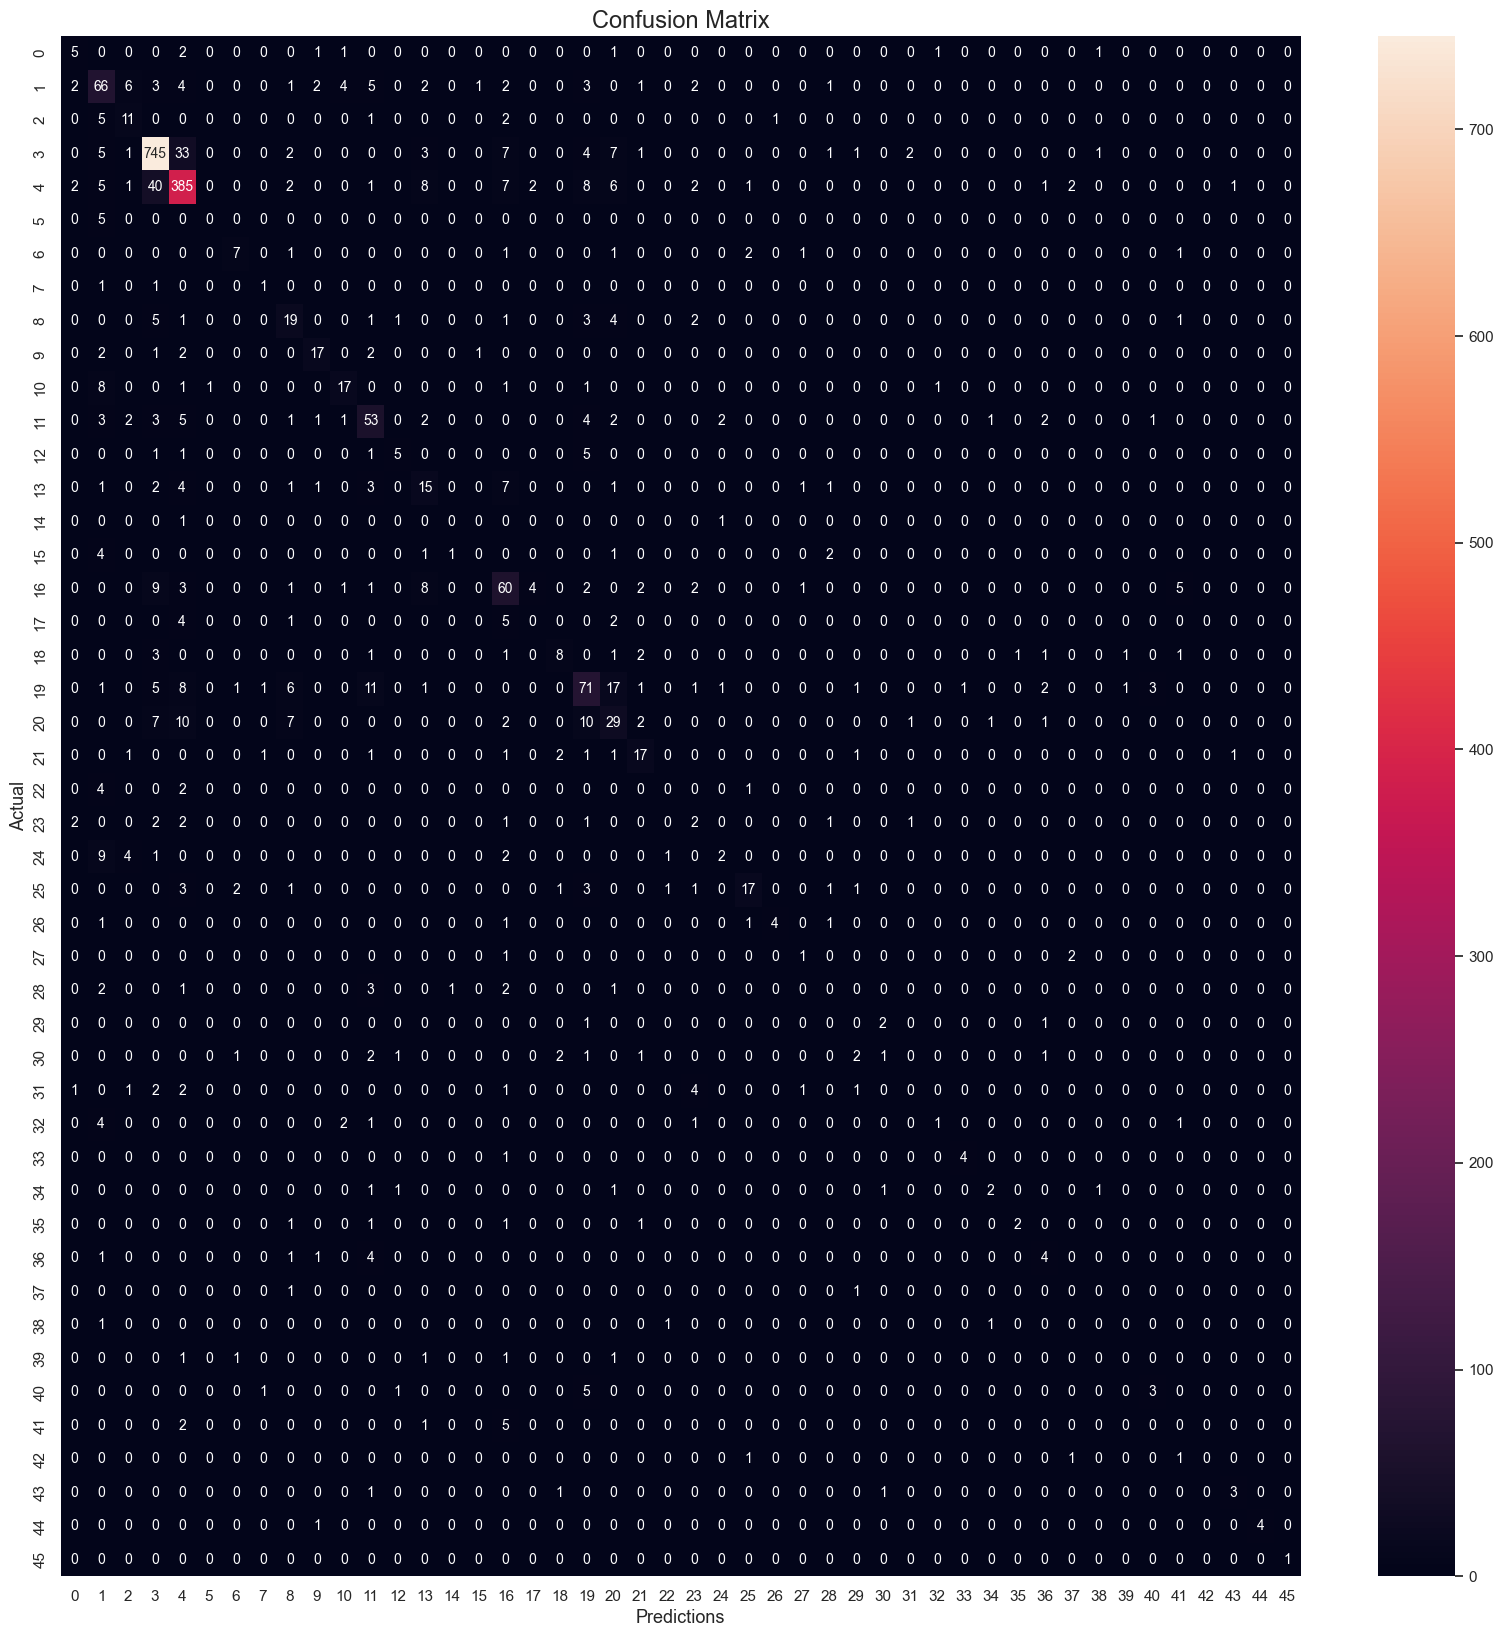

In [127]:
np.set_printoptions(precision=2, suppress=True)
import seaborn as sns
plt.figure(figsize=(20,20))
sns.set(rc={'figure.figsize':(8,8)})
sns.heatmap(confusion_matrix(y_test, pred_y), annot=True, annot_kws={"size": 10}, fmt='g')
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Predictions',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()